In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

# Cargar el dataset
bsd_train_path = '../../data/data_small/bike-sharing-demand/train.csv'
bsd_df = pd.read_csv(bsd_train_path, parse_dates=['datetime'])

bsd_df['datetime'] = pd.to_datetime(bsd_df['datetime'])
bsd_df['year'] = bsd_df['datetime'].dt.year
bsd_df['month'] = bsd_df['datetime'].dt.month
bsd_df['day'] = bsd_df['datetime'].dt.day
bsd_df['hour'] = bsd_df['datetime'].dt.hour
bsd_df['weekday'] = bsd_df['datetime'].dt.weekday
bsd_df['day_type'] = bsd_df['datetime'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Exploración inicial
print(f"Dimensiones iniciales: {bsd_df.shape}")

Dimensiones iniciales: (10886, 18)


In [2]:
print(f"Información del DataFrame: \n{bsd_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  weekday     10886 non-

In [3]:
print(f"Valores nulos por columna: \n{bsd_df.isnull().sum()}")
print()

Valores nulos por columna: 
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
weekday       0
day_type      0
dtype: int64



In [4]:
print(f"Filas duplicadas: \n{bsd_df.duplicated().sum()}")

# Eliminar duplicados (si los hay)
bsd_df = bsd_df.drop_duplicates()
print("Dimensiones tras eliminar duplicados:", bsd_df.shape)

Filas duplicadas: 
0
Dimensiones tras eliminar duplicados: (10886, 18)


In [5]:
# Simular valores nulos en 'temp'
df_with_nulls = bsd_df.copy()
np.random.seed(42)
mask = np.random.rand(len(df_with_nulls)) < 0.05
df_with_nulls.loc[mask, 'temp'] = np.nan
print("Valores nulos introducidos en 'temp':", df_with_nulls['temp'].isnull().sum())

# Imputar valores nulos
df_with_nulls['hour'] = df_with_nulls['datetime'].dt.hour
df_with_nulls['temp'] = df_with_nulls.groupby('hour')['temp'].transform(lambda x: x.fillna(x.median()))
print("Valores nulos tras imputación:", df_with_nulls['temp'].isnull().sum())

Valores nulos introducidos en 'temp': 538
Valores nulos tras imputación: 0


Número de outliers en 'count' (IQR): 300


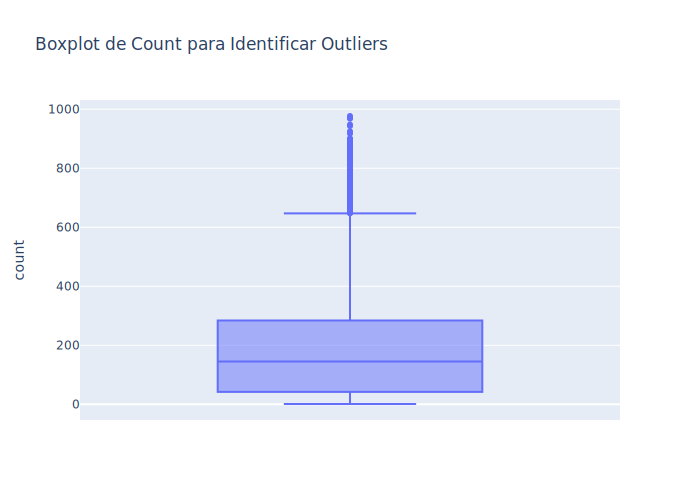

In [6]:
# Identificar outliers con IQR en 'count'
Q1 = bsd_df['count'].quantile(0.25)
Q3 = bsd_df['count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = bsd_df[(bsd_df['count'] < lower_bound) | (bsd_df['count'] > upper_bound)]
print("Número de outliers en 'count' (IQR):", len(outliers))

# Visualización de outliers
fig = px.box(bsd_df, y='count', title='Boxplot de Count para Identificar Outliers')
fig.show()

In [7]:
# Identificar outliers con Isolation Forest
X = bsd_df[['temp', 'humidity', 'windspeed', 'count']]
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(X) # 1 for inliers, -1 for outliers.
bsd_df['is_outlier'] = outlier_labels == -1
outliers_ml = bsd_df[bsd_df['is_outlier']]
print("Número de outliers detectados por Isolation Forest:", len(outliers_ml))

Número de outliers detectados por Isolation Forest: 109


In [8]:
# Marcar outliers en el dataset
bsd_df['outlier_iqr'] = (bsd_df['count'] < lower_bound) | (bsd_df['count'] > upper_bound)
print("Outliers marcados con IQR:", bsd_df['outlier_iqr'].sum())

Outliers marcados con IQR: 300


In [9]:
# Eliminar outliers identificados por IQR y Isolation Forest
bsd_df_cleaned = bsd_df[~bsd_df['outlier_iqr'] & ~bsd_df['is_outlier']]
print("Dimensiones tras eliminar outliers:", bsd_df_cleaned.shape)

Dimensiones tras eliminar outliers: (10522, 20)


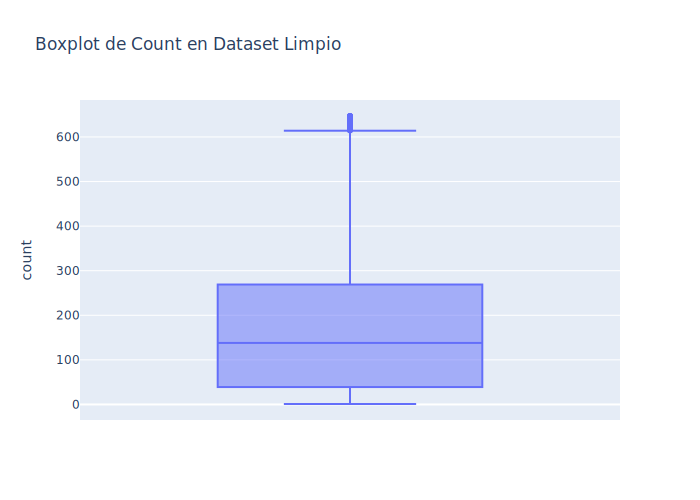

In [10]:
fig = px.box(bsd_df_cleaned, y='count', title='Boxplot de Count en Dataset Limpio')
fig.show()

In [11]:
# Guardar el dataset limpio
bsd_df_cleaned.to_csv('bike_sharing_cleaned.csv', index=False)
print("\nDataset limpio guardado como 'bike_sharing_cleaned.csv'.")


Dataset limpio guardado como 'bike_sharing_cleaned.csv'.
